# XGBoost Regressor 
The goal of this script is to document the generic steps in hyper parameter tuning and training an XGBoost Regression model.
This can be used to produce a baseline model to compare to, but in practice, more modifications will be necessary for fine tuning and creating the best possible model.
#### Useful Resources:
 - Source Documentation: https://xgboost.readthedocs.io/en/stable/
 - Blog Post on how XGBoost works and details of hyper parameter tuning: https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
 - Deep dive into important metrics and methods: https://coderzcolumn.com/tutorials/machine-learning/xgboost-an-in-depth-guide-python#3.1

In [1]:
##### Imports #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
# reduce_memory_usage optimizes the amount of memory required for each column. Pandas defaults to 64 bit data types, but this is wasteful.
# This function looks at the range of values and assigns the most optimal type that keeps the data in tact

# Source for this code: https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# Read in data and run reduce memory function
# SIMPLE TEST EXAMPLE USING CALIFORNIA HOUSING DATASET
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
data = pd.DataFrame(housing.data)
data.columns = housing.feature_names
data['MedHouseVal'] = housing.target
reduced_df = reduce_memory_usage(data)
X, y = reduced_df.loc[:,reduced_df.columns != 'MedHouseVal'], reduced_df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

Memory usage of dataframe is 1.42 MB
Memory usage after optimization is: 1.30 MB
Decreased by 8.3%


In [4]:
def XGB_Regressor_Training (xgb_params, scoring_param, X_train, X_test, y_train, y_test):
    # Parameter documentation: https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
    
    # Perform GridSearch
    start_time = time.time()
    grid = GridSearchCV(estimator=xgb.XGBRegressor(),param_grid=xgb_params, scoring = scoring_param, cv = 3, n_jobs = -1, verbose=True)
    grid.fit(X_train, y_train)
    
    # Report Results
    print('\nGrid Search Completed in:', round(time.time() - start_time,0),'seconds')
    print('Grid Search Best Parameters:',grid.best_params_,'\n')
    
    # Retrain using the best performing parameter combination
    # Define xgb specific data matrices
    dtrain = xgb.DMatrix(data=X_train.values,feature_names=X_train.columns,label=y_train.values)
    dtest = xgb.DMatrix(data=X_test.values,feature_names=X_test.columns,label=y_test.values)
    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    
    # Retrain using best parameters and optimized
    xgbr_tuned = xgb.train(params=grid.best_params_,dtrain=dtrain, num_boost_round=10, evals=evallist)   
    
    # Create predictions on test dataset
    xgbr_preds = xgbr_tuned.predict(dtest)
    
    # Store error metrics
    xgbr_error_metrics = {'mae':0,'rmse':0,'mse':0,'r2':0,'adjusted_r2':0}
    xgbr_error_metrics['mse'] = mean_squared_error(y_test, xgbr_preds)
    xgbr_error_metrics['rmse'] = np.sqrt(xgbr_error_metrics['mse'])
    xgbr_error_metrics['mae'] = mean_absolute_error(y_test, xgbr_preds)
    xgbr_error_metrics['r2'] = r2_score(y_test,xgbr_preds)
    n = y_test.shape[0] # Number of rows
    k = len(X_test.columns) # Number of independent variables
    xgbr_error_metrics['adjusted_r2'] = 1 - ((1-xgbr_error_metrics['r2'])*(n-1)/(n-k-1)) # Adjusted R^2 calculation
    
    # Print error metrics
    print("\n----------------- FINAL MODEL ERROR METRICS -----------------")
    print("MSE: %f" % (xgbr_error_metrics['mse']))
    print("RMSE: %f" % (xgbr_error_metrics['rmse']))
    print("MAE: %f" % (xgbr_error_metrics['mae']))
    print("R Squared: %f" % (xgbr_error_metrics['r2']))
    print("Adjusted R Squared: %f" % (xgbr_error_metrics['adjusted_r2']))
    
    # Returns the model, the best parameter list, predicted values, and common error metrics
    return xgbr_tuned, grid.best_params_, xgbr_preds, xgbr_error_metrics, xgbr_tuned.get_fscore(), dtrain, dtest
    

In [5]:
# Define XGBoost hyperparameters to optimize. 
# Parameter documentation: https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
xgb_params = {
          'objective':['reg:squarederror'], # 'reg:squarederror': for linear regression; 'reg:logistic': for logistic regression; 'binary:logistic': for logistic regression — with output of the probabilities
          'learning_rate': [0.05, 0.1, 0.3], # The learning rate determines the step size at each iteration while your model optimizes toward its objective. A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum. The value must be between 0 and 1. Default is 0.3
          'max_depth': [6, 8, 10], # The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit.The value must be an integer greater than 0. Default is 6.
          'num_parallel_tree': [50, 100], # The number of trees in our ensemble. Equivalent to the number of boosting rounds. The value must be an integer greater than 0. Default is 100.
          'subsample': [0.7], # Represents the fraction of observations to be sampled for each tree. A lower values prevent overfitting but might lead to under-fitting. The value must be between 0 and 1. Default is 1.
          'colsample_bytree': [0.3, 0.7], # Represents the fraction of columns to be randomly sampled for each tree. It might improve overfitting. The value must be between 0 and 1. Default is 1.
#           'alpha': [0, 1, 5, 10], # L1 regularization on the weights (Lasso Regression). When working with a large number of features, it might improve speed performances. It can be any integer. Default is 0.
#           'lambda': [0, 1, 5, 10], # lambda L2 regularization on the weights (Ridge Regression). It might help to reduce overfitting. It can be any integer. Default is 1.
#           'gamma': [0, 1, 5, 10], # Gamma is a pseudo-regularisation parameter (Lagrangian multiplier), and depends on the other parameters. The higher Gamma is, the higher the regularization. It can be any integer. Default is 0.
          'eval_metric':['rmse']}
scoring_param = 'neg_root_mean_squared_error' # Options: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Call the function to run hyperparameter optimization and training of final model
xgbr_model, xgbr_best_params, xgbr_preds, xgbr_error_metrics, xgbr_feature_importances, dtrain, dtest = XGB_Regressor_Training(xgb_params, scoring_param, X_train, X_test, y_train, y_test)


Fitting 3 folds for each of 36 candidates, totalling 108 fits

Grid Search Completed in: 1243.0 seconds
Grid Search Best Parameters: {'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'learning_rate': 0.3, 'max_depth': 8, 'num_parallel_tree': 100, 'objective': 'reg:squarederror', 'subsample': 0.7} 

[0]	eval-rmse:1.42429	train-rmse:1.44957
[1]	eval-rmse:1.09294	train-rmse:1.10245
[2]	eval-rmse:0.86816	train-rmse:0.86142
[3]	eval-rmse:0.72238	train-rmse:0.69993
[4]	eval-rmse:0.62986	train-rmse:0.59224
[5]	eval-rmse:0.57362	train-rmse:0.52209
[6]	eval-rmse:0.53802	train-rmse:0.47481
[7]	eval-rmse:0.51607	train-rmse:0.44268
[8]	eval-rmse:0.50217	train-rmse:0.42008
[9]	eval-rmse:0.49221	train-rmse:0.40287

----------------- FINAL MODEL ERROR METRICS -----------------
MSE: 0.242272
RMSE: 0.492211
MAE: 0.328681
R Squared: 0.815317
Adjusted R Squared: 0.814959


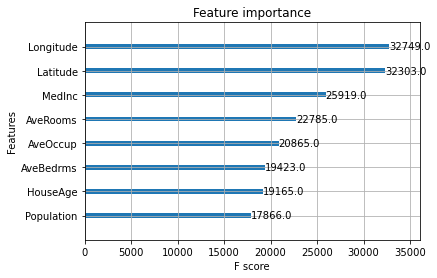

In [6]:
# Display plot of XGBoost feature importances
xgb.plot_importance(xgbr_model)
plt.rcParams['figure.figsize'] = [4, 15]
plt.show()

In [7]:
# Display plot of first tree
xgb.plot_tree(xgbr_model,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 20]
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.809242 to fit


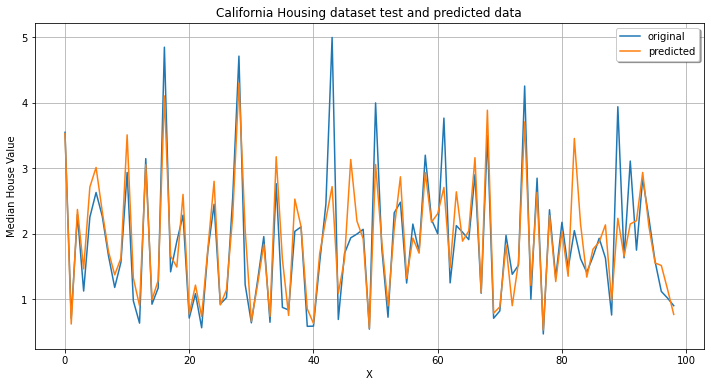

In [8]:
# Display plot of 100 observations vs predicted
num_observations=100
x_ax = range(len(y_test[0:num_observations-1]))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test[0:num_observations-1], label="original")
plt.plot(x_ax, xgbr_preds[0:num_observations-1], label="predicted")
plt.title("California Housing dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Median House Value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

In [9]:
# Save the model
pickle.dump(xgbr_model, open("xgbr_model.pkl", "wb"))

# Save test DMatrix
dtest.save_binary('dtest.buffer')

In [10]:
# load the model
xgbr_model_loaded = pickle.load(open("xgbr_model.pkl", "rb"))

# Load test DMatrix 
dtest2 = xgb.DMatrix('dtest.buffer')

In [11]:
# Sanity Checks to ensure model is the same as before
print("----------------- SANITY CHECKS -----------------")
print("Is the sum of difference between predictions zero?",(xgbr_model.predict(dtest) - xgbr_model_loaded.predict(dtest2)).sum() == 0.0)
print("Do the feature importances dictionaries match?",xgbr_model.get_fscore() == xgbr_model_loaded.get_fscore())

----------------- SANITY CHECKS -----------------
Is the sum of difference between predictions zero? True
Do the feature importances dictionaries match? True
